# Quantum Feature Selection

This notebook is an extension of the work presented by [1]. The author's main goal was to develop a way to screen candidate feature maps using classical computers in order to find the best one to use on quantum hardware. This was done by classically computing the quantum data states in the feature space and computing a minimum accuracy score by iterating through each of the 16 dimensions and finding the best hyperplane to separate the data on a single axis. This represents a worst-case scenario by limiting the hyperplane to just one axis but gives a lower bound on the expected training accuracy that a SVC could achieve on the dataset given that particular feature map.

The authors admit that this calculation works for 2 qubits but is not feasible for more qubits becuase the dimensions grow exponentially. Thus, the work in this notebook work look at several different methods to compute a minimum accuracy more efficiently than the brute force calculation of looking through all dimensions and all possible hyperplanes.

In [1]:
import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger()
logger.info("Setting up logger for notebook.")

INFO:root:Setting up logger for notebook.


## Data

Below are the toy datasets that the paper explores: circles, exponential, moons, and exclusive or.

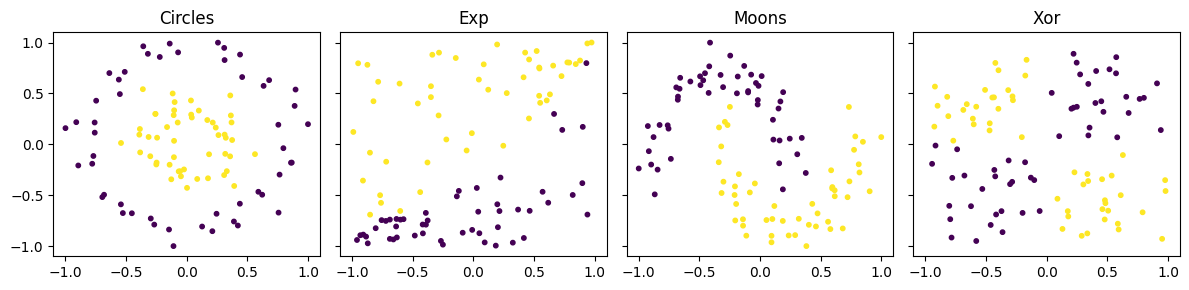

In [2]:
import matplotlib.pyplot as plt
from data_processing import make_datasets


toy_dataset = make_datasets(n_samples=100, seed=42)
DATASET_NAMES = list(toy_dataset.keys())

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 3), sharex=True, sharey=True)
axs[0].scatter(toy_dataset['circles']['X'][:, 0], toy_dataset['circles']['X'][:, 1], c=toy_dataset['circles']['y'], s=10)
axs[1].scatter(toy_dataset['exp']['X'][:, 0], toy_dataset['exp']['X'][:, 1], c=toy_dataset['exp']['y'], s=10)
axs[2].scatter(toy_dataset['moons']['X'][:, 0], toy_dataset['moons']['X'][:, 1], c=toy_dataset['moons']['y'], s=10)
axs[3].scatter(toy_dataset['xor']['X'][:, 0], toy_dataset['xor']['X'][:, 1], c=toy_dataset['xor']['y'], s=10)
axs[0].set_title('Circles')
axs[1].set_title('Exp')
axs[2].set_title('Moons')
axs[3].set_title('Xor')

plt.tight_layout()
plt.show()

## Pauli Decomposition

The original function used in the work to recreate the results of the paper did a Pauli decomposition to get the coefficients for all 16 dimensions of the feature space for the dataset. However, this calculation grows exponentially in size with the number of qubits and thus a more efficient minimum accuracy calculation will not require all the coefficients for each datapoint. Therefore, the updated function, `compute_pauli_decomposition`, will take a list of axis indices for which to compute the coefficients. When passed a list 0-15, it will give the coefficients back for all 16 dimensions which should match the functionality and results of the original function. Below we can test that this does create the same 2D array.

In [3]:
import numpy as np
from feature_maps import encoding_fns, param_circuit
from minimum_accuracy import convert_to_pauli_decomposition, compute_pauli_decomposition


# Test that both methods produce the same quantum representation of the dataset to verify methodology
np.testing.assert_allclose(
    convert_to_pauli_decomposition(toy_dataset['circles']['X'], encoding_fns['encoding_fn_1'])[0],
    compute_pauli_decomposition(toy_dataset['circles']['X'], param_circuit(encoding_fns['encoding_fn_1']), list(np.arange(16)))
)

## Random Selection

The first method will be an approximation of the minimum accuracy by randomly selecting a portion of the 16 Pauli axes for batches of data. Due to the small dataset size (100 in total with each cross fold validation using only 20 datapoints), there is a limitation in the number of options for batch size. To ensure equal batch sizes, we can select 4 or 10 which would require 5 or 2 batches to process. I've selected a batch size of 10 which looks at only 2 batches per cross-fold validatioin to ensure that the batch has enough data points to reveal the most prominent features of the underlying distributions. The other parameter which could be tweaked in the method below is the number of randomly chosen axes to compute in the Pauli decomposition. With only 2 batches per cross-fold validation, it makes sense to compute a larger portion of axes but in general, if the data could be split into more batches, a smaller number of axes could be selected. For each batch of data, a random subset of Pauli axes are computed and the best accuracy score on a single axis is found. This is repeated for all batches of data and the best accuracy is kept. The number of Pauli decomposition evaluations is uniform for each dataset and feature map: its the number of axes computed for each datapoint in a batch times the number of batches. 

In [4]:
import math
import xarray as xr
from minimum_accuracy import get_all_accuracies

# Data parameters
cv_num = 30
training_pct = 0.5
N = 40
data_seed = 112120231

# Random Selection parameters. batch_size and num_axes can be tweaked
batch_size = 10
num_axes = 5
num_points = int(N * training_pct)
num_batches = math.ceil(num_points / batch_size)


# Store results
min_test_accuracy = np.empty((cv_num, len(DATASET_NAMES), len(encoding_fns)))
num_features_eval = np.empty((cv_num, len(DATASET_NAMES), len(encoding_fns)))


# Use same number of cross validations and random seeds as above so we can compare
for cv_id in np.arange(cv_num):
    datasets = make_datasets(n_samples=N, training_pct=training_pct, seed=data_seed+cv_id)

    for ef_idx, encoding_fn in enumerate(encoding_fns.values()):
        feature_map = param_circuit(encoding_fn=encoding_fn)

        for ds_idx, dataset in enumerate(datasets):

            # Process dataset in batches for random axes
            max_batch_acc = 0
            for i in range(0, num_points, batch_size):
                # Select random axes to compute
                random_axes = np.random.choice(16, size=num_axes, replace=False)

                labels = datasets[dataset]['train']['y'][i:i+batch_size]
                quantum_ds = compute_pauli_decomposition(
                    ds=datasets[dataset]['train']['X'][i:i+batch_size],
                    feature_map=feature_map,
                    axes=random_axes
                )
                
                # Find optimal hyperplane and compute best accuracy
                accuracies = get_all_accuracies(quantum_ds, labels)
                max_batch_acc = max(max_batch_acc, max(accuracies))

            min_test_accuracy[cv_id][ds_idx][ef_idx] = max_batch_acc

    logger.info(f"Trained models for cross fold validation {cv_id}")


# Format results in xarray dataset
min_test_accuracy_ds = xr.Dataset(
    data_vars={
        "accuracy":(
            ["cv_id", "dataset", "feature_map"],
            min_test_accuracy
        ),
        "max_evaluations":(
            ["cv_id", "dataset", "feature_map"],
            num_axes*batch_size*num_batches*np.ones_like(min_test_accuracy)
        )
    },
    coords={
        "cv_id": np.arange(cv_num),
        "dataset": DATASET_NAMES,
        "feature_map": list(encoding_fns.keys())
    }
).transpose("cv_id", "feature_map", "dataset")

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:root:Trained models for cross fold validation 0
INFO:root:Trained models for cross fold validation 1
INFO:root:Trained models for cross fold validation 2
INFO:root:Trained models for cross fold validation 3
INFO:root:Trained models for cross fold validation 4
INFO:root:Trained models for cross fold validation 5
INFO:root:Trained models for cross fold validation 6
INFO:root:Trained models for cross fold validation 7
INFO:root:Trained models for cross fold validation 8
INFO:root:Trained models for cross fold validation 9
INFO:root:Trained models for cross fold validation 10
INFO:root:Trained models for cross fold validation 11
INFO:root:Trained models for cross fold validation 12
INFO:root:Trained models for cross fold validation 13
INFO:root:Trained models for cross fold validation 14
INFO:root:Trained models for cro

In [5]:
min_test_accuracy_ds.accuracy.mean('cv_id').to_pandas()

dataset,circles,exp,moons,xor
feature_map,,,,
encoding_fn_1,0.980000,0.910000,0.890000,0.966667
encoding_fn_2,0.960000,0.913333,0.906667,0.953333
encoding_fn_3,0.986667,0.953333,0.953333,0.930000
encoding_fn_4,0.996667,0.916667,0.916667,0.910000
encoding_fn_5,1.000000,0.940000,0.933333,0.926667


In [6]:
min_test_accuracy_ds.max_evaluations.mean('cv_id').to_pandas()

dataset,circles,exp,moons,xor
feature_map,,,,
encoding_fn_1,100.0,100.0,100.0,100.0
encoding_fn_2,100.0,100.0,100.0,100.0
encoding_fn_3,100.0,100.0,100.0,100.0
encoding_fn_4,100.0,100.0,100.0,100.0
encoding_fn_5,100.0,100.0,100.0,100.0


In [7]:
total_pauli_decomps = 20*30*4*5*16
min_test_accuracy_ds.max_evaluations.sum().values/total_pauli_decomps

0.3125

Random selection reduces the number of Pauli decomposition computations down to 31.25% of the original method proposed in [1]. However, this method doesn't quite reveal the divergences in skill across the feature maps that we would expect compared to the actual computed minimum accuracy scores. We do see that feature map 1 performs best on the exclusive OR dataset and that encoding feature 3 scores highest for the exponential dataset but the best scores are only marginally higher than the next best feature maps compared to the more clear winners from the original method. Furthermore, we don't see the same feature map performing the best for the moons dataset.

## Adaptive Feature Selection

The Adaptive Feature Selection process will process the data in pairs of balanced datapoints. Starting with 4 datapoints, it will compute the accuracies of the best hyperplane along each of the 16 Pauli axes and then select the best subset of axes. Then, it will process the next 2 datapoints and compute the accuracies of those 6 datapoints along the subset of previously selected Pauli axes. It keeps repeating this process of processing more datapoints but on a shrinkinig subset of the Pauli axes until some stopping criteria is met regarding the minimum number of datapoints. Sometimes, only one axis remains at this point and it computes the accuracy on that single axis; other times, there will be multiple axes still in play but they have comparable enough accuracies that the maximum is selected.

The subset of Pauli axes selected on each iteration is determined by looking at the mean and standard deviation of accuracy scores achieved by each of the Pauli axes in play. An adaptive cutoff is calculated at each iteration based on some number of standard deviations below the mean accuracy score and all axes that perform better than that continue on. The rate of which the axes discarded at each iteration can be controlled via the `adaptive_rate` and `initial_stds` parameters below. The `adaptive_rate` parameter asseses the exponential rate by which the number of standard deviations below the mean shrinks on each iteration and the `initial_std` is the initial number of standard deviations and determines how aggressive to cut on the first iteration.

In [8]:
# Adaptive Feature Selection parameters
initial_stds = 2.0
adaptive_rate = 2.5
early_stopping = True
min_pts_eval = 0.5 * num_points

# Store results
min_test_accuracy = np.empty((cv_num, len(DATASET_NAMES), len(encoding_fns)))
num_features_eval = np.empty((cv_num, len(DATASET_NAMES), len(encoding_fns)))


# Use same number of cross validations and random seeds as above so we can compare
for cv_id in np.arange(cv_num):
    datasets = make_datasets(n_samples=N, training_pct=training_pct, seed=data_seed+cv_id)

    for ef_idx, encoding_fn in enumerate(encoding_fns.values()):
        feature_map = param_circuit(encoding_fn=encoding_fn)
        
        for ds_idx, dataset in enumerate(datasets):
            # Allocate space for quantum dataset, initialize pauli axes, and keep track of axis evals
            quantum_ds = np.zeros((datasets[dataset]['train']['X'].shape[0], 16))
            axes_idxs = np.arange(1, 16)
            pauli_evals = 0

            # Process data in pair batches
            for idx in range(0, num_points, 2):
                quantum_ds[idx:idx+2, axes_idxs] = compute_pauli_decomposition(
                    datasets[dataset]['train']['X'][idx:idx+2, :],
                    feature_map=feature_map,
                    axes=axes_idxs
                )
                labels = datasets[dataset]['train']['y'][0:idx+2]
                pauli_evals+=2*len(axes_idxs)


                # Skip case of only 2 datapoints
                if idx == 0:
                    continue

                # Compute accuracies for subset of axes
                accuracies = get_all_accuracies(quantum_ds[0:idx+2, axes_idxs], labels)
                acc_std = accuracies.std()
                num_stds = initial_stds*np.exp(-idx*adaptive_rate)
                scores_min = accuracies.mean() - num_stds*acc_std

                # Update selection of axes so long as accuracies scores aren't all the same (non-zero std)
                # and more than 1 still remain
                if acc_std > 1e-8 and len(axes_idxs) > 1:
                    axes_idxs = axes_idxs[np.where(accuracies >= scores_min)[0]]

                # Early stopping case if minimum number of datapoints have been processed
                if early_stopping and idx >= min_pts_eval:
                   break

            min_test_accuracy[cv_id][ds_idx][ef_idx] = max(accuracies)
            num_features_eval[cv_id][ds_idx][ef_idx] = pauli_evals

    logger.info(f"Trained models for cross fold validation {cv_id}")            



# Format results in xarray dataset
min_test_accuracy_ds = xr.Dataset(
    data_vars={
        "accuracy":(["cv_id", "dataset", "feature_map"], min_test_accuracy),
        "max_evaluations": (["cv_id", "dataset", "feature_map"], num_features_eval)
    },
    coords={
        "cv_id": np.arange(cv_num),
        "dataset": DATASET_NAMES,
        "feature_map": list(encoding_fns.keys())
    }
).transpose("cv_id", "feature_map", "dataset")

INFO:root:Trained models for cross fold validation 0
INFO:root:Trained models for cross fold validation 1
INFO:root:Trained models for cross fold validation 2
INFO:root:Trained models for cross fold validation 3
INFO:root:Trained models for cross fold validation 4
INFO:root:Trained models for cross fold validation 5
INFO:root:Trained models for cross fold validation 6
INFO:root:Trained models for cross fold validation 7
INFO:root:Trained models for cross fold validation 8
INFO:root:Trained models for cross fold validation 9
INFO:root:Trained models for cross fold validation 10
INFO:root:Trained models for cross fold validation 11
INFO:root:Trained models for cross fold validation 12
INFO:root:Trained models for cross fold validation 13
INFO:root:Trained models for cross fold validation 14
INFO:root:Trained models for cross fold validation 15
INFO:root:Trained models for cross fold validation 16
INFO:root:Trained models for cross fold validation 17
INFO:root:Trained models for cross fol

In [9]:
total_pauli_decomps = 20*30*4*5*16
min_test_accuracy_ds.max_evaluations.sum().values/total_pauli_decomps

0.27911458333333333

In [10]:
min_test_accuracy_ds.accuracy.mean('cv_id').to_pandas()

dataset,circles,exp,moons,xor
feature_map,,,,
encoding_fn_1,1.0,0.861111,0.888889,0.977778
encoding_fn_2,1.0,0.875000,0.883333,0.930556
encoding_fn_3,1.0,0.950000,0.933333,0.913889
encoding_fn_4,1.0,0.891667,0.933333,0.877778
encoding_fn_5,1.0,0.877778,0.930556,0.866667


In [11]:
min_test_accuracy_ds.max_evaluations.mean('cv_id').to_pandas()

dataset,circles,exp,moons,xor
feature_map,,,,
encoding_fn_1,92.000000,88.133333,81.600000,88.133333
encoding_fn_2,85.933333,84.666667,87.200000,89.400000
encoding_fn_3,95.933333,93.600000,90.666667,84.800000
encoding_fn_4,101.200000,88.333333,82.866667,86.866667
encoding_fn_5,101.400000,90.266667,87.933333,85.400000


Using the adaptive feature selection method, the number of Pauli decomposition calculations was reduced to 27.9% of the number required by the original method. Additionally, the approximate minimum accuracy scores look much closer to the original values computed. For example, it finds a minimum score of 100% for all feature maps on the circles dataset whiich is the same as the original method. It also clearly identifies feature map 1 as the most suitable for the exclusive OR dataset and feature map 3 for the exponential dataset, both scoring accuracies that are very close to the original values computed. Lastly, it does not identify the same best feature map for the moons dataset but shows that feature maps 3-5 all perform very closely to one another which is exactly what we see in the actual minimum accuracy scores. Overall, this method worked well in efficiently predicting which feature map would have the best training accuracy on a dataset.

We can also analyze the reduction in computations that this method achieved. While the random selection had uniform computation for feature map, dataset, cross-fold validation, and data batch, the adapative selection approach dynamically allocates more computations only when needed. For instance, we see that the encoding function 1 for the moons dataset only required an average of 81.6 Pauli axes evaluations in order to approximate the accuracy whereas encoding function 5 in the circles dataset required nearly 25% more Pauli axis evaluations. In general, the circles dataset required the most evaluations despite being the easiest dataset for all feature maps. This is due to multiple axes performing equally well and the adaptive feature selection algorithm being unable to drop off axes at each iteration. Without a clear winner early on, a handful of axes gets processed until the early stopping criteria is met and then the best accuracy of the remaining axes is selected.

## Additional Dataset

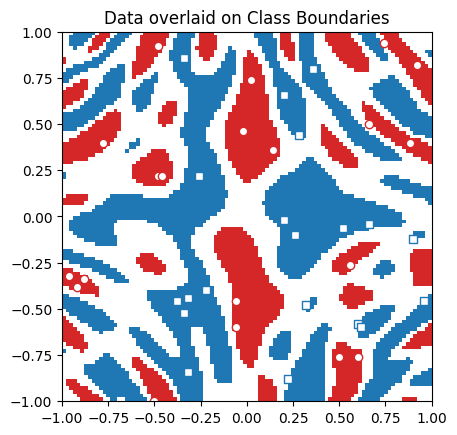

In [12]:
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.datasets import ad_hoc_data
from matplotlib.colors import ListedColormap

algorithm_globals.random_seed = 12345

train_data, train_labels, test_data, test_labels, sample_total = ad_hoc_data(
    training_size=20,
    test_size=0,
    n=2,
    gap=0.3,
    include_sample_total=True,
    one_hot=False
)

# Put data on -1 to 1 scale
train_data = train_data/np.pi - 1
test_data = test_data/np.pi - 1
sample_total = sample_total/np.pi - 1

# Plot data and class boundaries
fig, ax = plt.subplots()

cmap = ListedColormap(["C3","w","C0"])

ax.set_title("Data overlaid on Class Boundaries")
ax.set_ylim(-1, 1)
ax.set_xlim(-1, 1)
ax.imshow(
    np.asmatrix(sample_total).T,
    interpolation='nearest',
    origin='lower',
    cmap=cmap,
    extent=[-1, 1, -1, 1]
)
ax.scatter(
    train_data[np.where(train_labels[:] == 0), 0],
    train_data[np.where(train_labels[:] == 0), 1],
    marker='s',
    facecolors='w',
    edgecolors='C0',
    label="A"
)
ax.scatter(
    train_data[np.where(train_labels[:] == 1), 0],
    train_data[np.where(train_labels[:] == 1), 1],
    marker='o',
    facecolors='w',
    edgecolors='C3',
    label="B"
)
plt.show()

In [13]:
from data_processing import make_adhoc_dataset
from feature_maps import calculate_kernel
from sklearn.svm import SVC
from qiskit.circuit.library import ZZFeatureMap

# Store results
cv_num = 30
results_train = np.empty((cv_num, len(encoding_fns)+1))
results_test = np.empty((cv_num, len(encoding_fns)+1))


# Define all the settings for running this exactly as the paper (except random seeds)
training_pct = 0.5
N = 40
c = 10e10 # this implements hard-margin SVM but could be overfitting
data_seed = 112120231
sampler_seed = 112120232
shots = 10000
backend='qasm_simulator'

# Make dataset sampled from a ZZ FeatureMap
adhoc_ds = make_adhoc_dataset(n_samples=N, training_pct=training_pct, cv_num=cv_num, seed=12345)

for cv_id in np.arange(cv_num):
    logger.info(f"Training models for cross fold validation {cv_id}")
    
    for ef_idx in np.arange(len(encoding_fns)+1):
        # First, precompute our kernels
        if ef_idx < 5:
            feature_map = param_circuit(list(encoding_fns.values())[ef_idx])
        else:
            feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement="linear")

        train_kernel = calculate_kernel(
            feature_map=feature_map,
            train_X=adhoc_ds['train']['X'][cv_id],
            shots=shots,
            sampler_seed=sampler_seed,
            backend=backend
        )
        test_kernel = calculate_kernel(
            feature_map=feature_map,
            train_X=adhoc_ds['train']['X'][cv_id],
            test_X=adhoc_ds['test']['X'][cv_id],
            shots=shots,
            sampler_seed=sampler_seed,
            backend=backend
        )

        # Then fit our support vector classifier
        model = SVC(kernel='precomputed', C=c)
        model = model.fit(train_kernel, adhoc_ds['train']['y'][cv_id])

        # Lastly, score our training accuracy and test accuracy and store results
        train_acc = model.score(train_kernel, adhoc_ds['train']['y'][cv_id])
        test_acc = model.score(test_kernel, adhoc_ds['test']['y'][cv_id])
        results_train[cv_id][ef_idx] = train_acc
        results_test[cv_id][ef_idx] = test_acc


adhoc_ds_results_ds = xr.Dataset(
    data_vars={
        "train":(["cv_id", "feature_map"], results_train),
        "test": (["cv_id", "feature_map"], results_test)
    },
    coords={"cv_id": np.arange(cv_num), "feature_map": list(encoding_fns.keys()) + ['ZZFeatureMap']},
    attrs={"n_samples": N, "training_pct": training_pct}
).transpose("cv_id", "feature_map")

INFO:root:Training models for cross fold validation 0
INFO:root:Training models for cross fold validation 1
INFO:root:Training models for cross fold validation 2
INFO:root:Training models for cross fold validation 3
INFO:root:Training models for cross fold validation 4
INFO:root:Training models for cross fold validation 5
INFO:root:Training models for cross fold validation 6
INFO:root:Training models for cross fold validation 7
INFO:root:Training models for cross fold validation 8
INFO:root:Training models for cross fold validation 9
INFO:root:Training models for cross fold validation 10
INFO:root:Training models for cross fold validation 11
INFO:root:Training models for cross fold validation 12
INFO:root:Training models for cross fold validation 13
INFO:root:Training models for cross fold validation 14
INFO:root:Training models for cross fold validation 15
INFO:root:Training models for cross fold validation 16
INFO:root:Training models for cross fold validation 17
INFO:root:Training m

In [14]:
adhoc_ds_results_ds.train.mean('cv_id').to_pandas()

feature_map
encoding_fn_1    1.000000
encoding_fn_2    1.000000
encoding_fn_3    0.983333
encoding_fn_4    1.000000
encoding_fn_5    1.000000
ZZFeatureMap     1.000000
dtype: float64

In [15]:
adhoc_ds_results_ds.test.mean('cv_id').to_pandas()

feature_map
encoding_fn_1    0.536667
encoding_fn_2    0.538333
encoding_fn_3    0.480000
encoding_fn_4    0.520000
encoding_fn_5    0.540000
ZZFeatureMap     0.556667
dtype: float64

Not surprisingly, all the feature maps performed very poorly on this dataset. Considering that we figured that the feature maps that performed best were ones that produced patterns that modeled the data well, it makes sense that none of the feature maps produced patterns that resembled the arbitrary

## References

1. https://arxiv.org/pdf/1906.10467.pdf